<a href="https://colab.research.google.com/github/menna03/Food101/blob/main/Working_Pytorch_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

#  Preprocessing: Transforming the Raw Material

In [ ]:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Enhanced Data Preparation with Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),# Resize: Resizes images to a fixed size of 224x224 pixels.
    transforms.RandomHorizontalFlip(), # Randomly flips the image horizontally
    transforms.RandomRotation(10),  # Random rotation for added variability
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # adjusts the brightness, contrast, saturation, and hue to add more variability and robustness.
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  #  Randomly crops and resizes the image to 224x224 pixels, focusing on different parts of the image.
    transforms.ToTensor(), # Converts the image to a PyTorch tensor.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalizes the image tensor using the mean and standard deviation values specific to the dataset
])

# Load the datasets
train_dataset = torchvision.datasets.Food101(root='./data', split='train', transform=transform, download=True)
test_dataset = torchvision.datasets.Food101(root='./data', split='test', transform=transform, download=True)

# Subset the training data to 25%
subset_size = int(len(train_dataset) * 0.25) # This part reduces the training dataset to 25% of its original size:
subset_indices = torch.randperm(len(train_dataset))[:subset_size] #  Generates a random permutation of indices and selects the first 25% of them.
train_subset = Subset(train_dataset, subset_indices) # Creates a subset of the training data using the selected indices.

# Data loaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)  # Loads the training data in batches of 32, shuffling the data at each epoch.
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # Loads the testing data in batches of 32, without shuffling (preserving order).


100%|██████████| 4996278331/4996278331 [03:45<00:00, 22129180.86it/s]


Extracting ./data/food-101.tar.gz to ./data


# •	Visualization

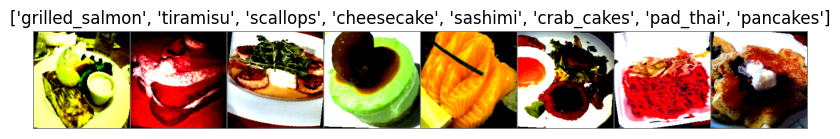

Number of samples in train_subset: 18937
Shape of each image: torch.Size([3, 224, 224])
Label of the first image: 16


In [ ]:
# Function to display a batch of images with their labels
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)  # Clip values to [0, 1] range
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Get a batch of training images and labels
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Map class indices to labels
class_names = train_dataset.classes

# Display the images with labels
imshow(torchvision.utils.make_grid(images[:8]), [class_names[labels[j]] for j in range(8)])

# Number of samples in the subset
num_samples = len(train_subset)

# Shape of one sample (image and label)
image, label = train_subset[0]  # Get the first image and label

print(f"Number of samples in train_subset: {num_samples}")
print(f"Shape of each image: {image.shape}")
print(f"Label of the first image: {label}")  # Prints the label of the first image


# Training  🥳

In [ ]:
# Step 2: Modified ResNet50 with Dropout
class ModifiedResNet50(nn.Module):
    def __init__(self):
        super(ModifiedResNet50, self).__init__()
        # Load ResNet50 with pretrained weights
        self.model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        num_features = self.model.fc.in_features  # Get the number of input features of the original fully connected layer

        # Replace the final fully connected layer with dropout and output layer
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),                   # Add dropout layer to prevent overfitting
            nn.Linear(num_features, 101)       # New fully connected layer with 101 output classes
        )

        # Unfreeze the last 10 layers for fine-tuning
        for name, param in self.model.named_parameters():
            param.requires_grad = False        # Freeze all layers initially

        for name, param in list(self.model.named_parameters())[-20:]:  # Unfreeze the last 20 layers
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)  # Forward pass through the modified model

model = ModifiedResNet50().to(device)  # Instantiate the model and move it to the GPU (or CPU)

# Step 3: Define Loss Function, Optimizer, and Scheduler with Weight Decay
criterion = nn.CrossEntropyLoss()  # Define cross-entropy loss for multi-class classification

# Optimizer with weight decay for regularization
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=1e-4)  # Adam optimizer with weight decay

# Learning rate scheduler to reduce learning rate on plateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)  # Reduce LR if validation loss plateaus

# Step 4: Training Loop with Accuracy Calculation and Early Stopping
num_epochs = 15                   # Number of epochs to train
best_val_loss = float('inf')      # Track the best validation loss
early_stopping_patience = 5       # Number of epochs to wait for improvement before stopping
early_stopping_counter = 0        # Counter to track early stopping

for epoch in range(num_epochs):
    model.train()                 # Set the model to training mode
    running_loss = 0.0            # Initialize running loss
    correct_predictions = 0       # Track number of correct predictions
    total_predictions = 0         # Track total predictions made

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device

        optimizer.zero_grad()      # Zero the gradients

        outputs = model(images)    # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()            # Backpropagation
        optimizer.step()           # Update weights

        running_loss += loss.item()  # Accumulate the loss
        _, predicted = torch.max(outputs, 1)  # Get predicted classes
        correct_predictions += (predicted == labels).sum().item()  # Count correct predictions
        total_predictions += labels.size(0)  # Count total predictions

    # Calculate and print loss and accuracy for each epoch
    train_accuracy = correct_predictions / total_predictions * 100  # Calculate training accuracy
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%", flush=True)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 58.8MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/15], Loss: 3.5006, Accuracy: 20.75%
Epoch [2/15], Loss: 2.3480, Accuracy: 42.43%
Epoch [3/15], Loss: 1.9796, Accuracy: 49.77%
Epoch [4/15], Loss: 1.7473, Accuracy: 55.20%
Epoch [5/15], Loss: 1.5761, Accuracy: 58.83%
Epoch [6/15], Loss: 1.4551, Accuracy: 61.34%
Epoch [7/15], Loss: 1.3234, Accuracy: 64.59%
Epoch [8/15], Loss: 1.2384, Accuracy: 66.64%
Epoch [9/15], Loss: 1.1446, Accuracy: 68.91%
Epoch [10/15], Loss: 1.0768, Accuracy: 70.54%
Epoch [11/15], Loss: 0.9873, Accuracy: 72.88%
Epoch [12/15], Loss: 0.9231, Accuracy: 74.18%
Epoch [13/15], Loss: 0.8638, Accuracy: 76.00%
Epoch [14/15], Loss: 0.8243, Accuracy: 76.57%
Epoch [15/15], Loss: 0.7546, Accuracy: 78.69%


# 5. Evaluation:

<ipython-input-9-42d9765f54da>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable mixed precision during evaluation


Test Accuracy on the full test set: 65.61%


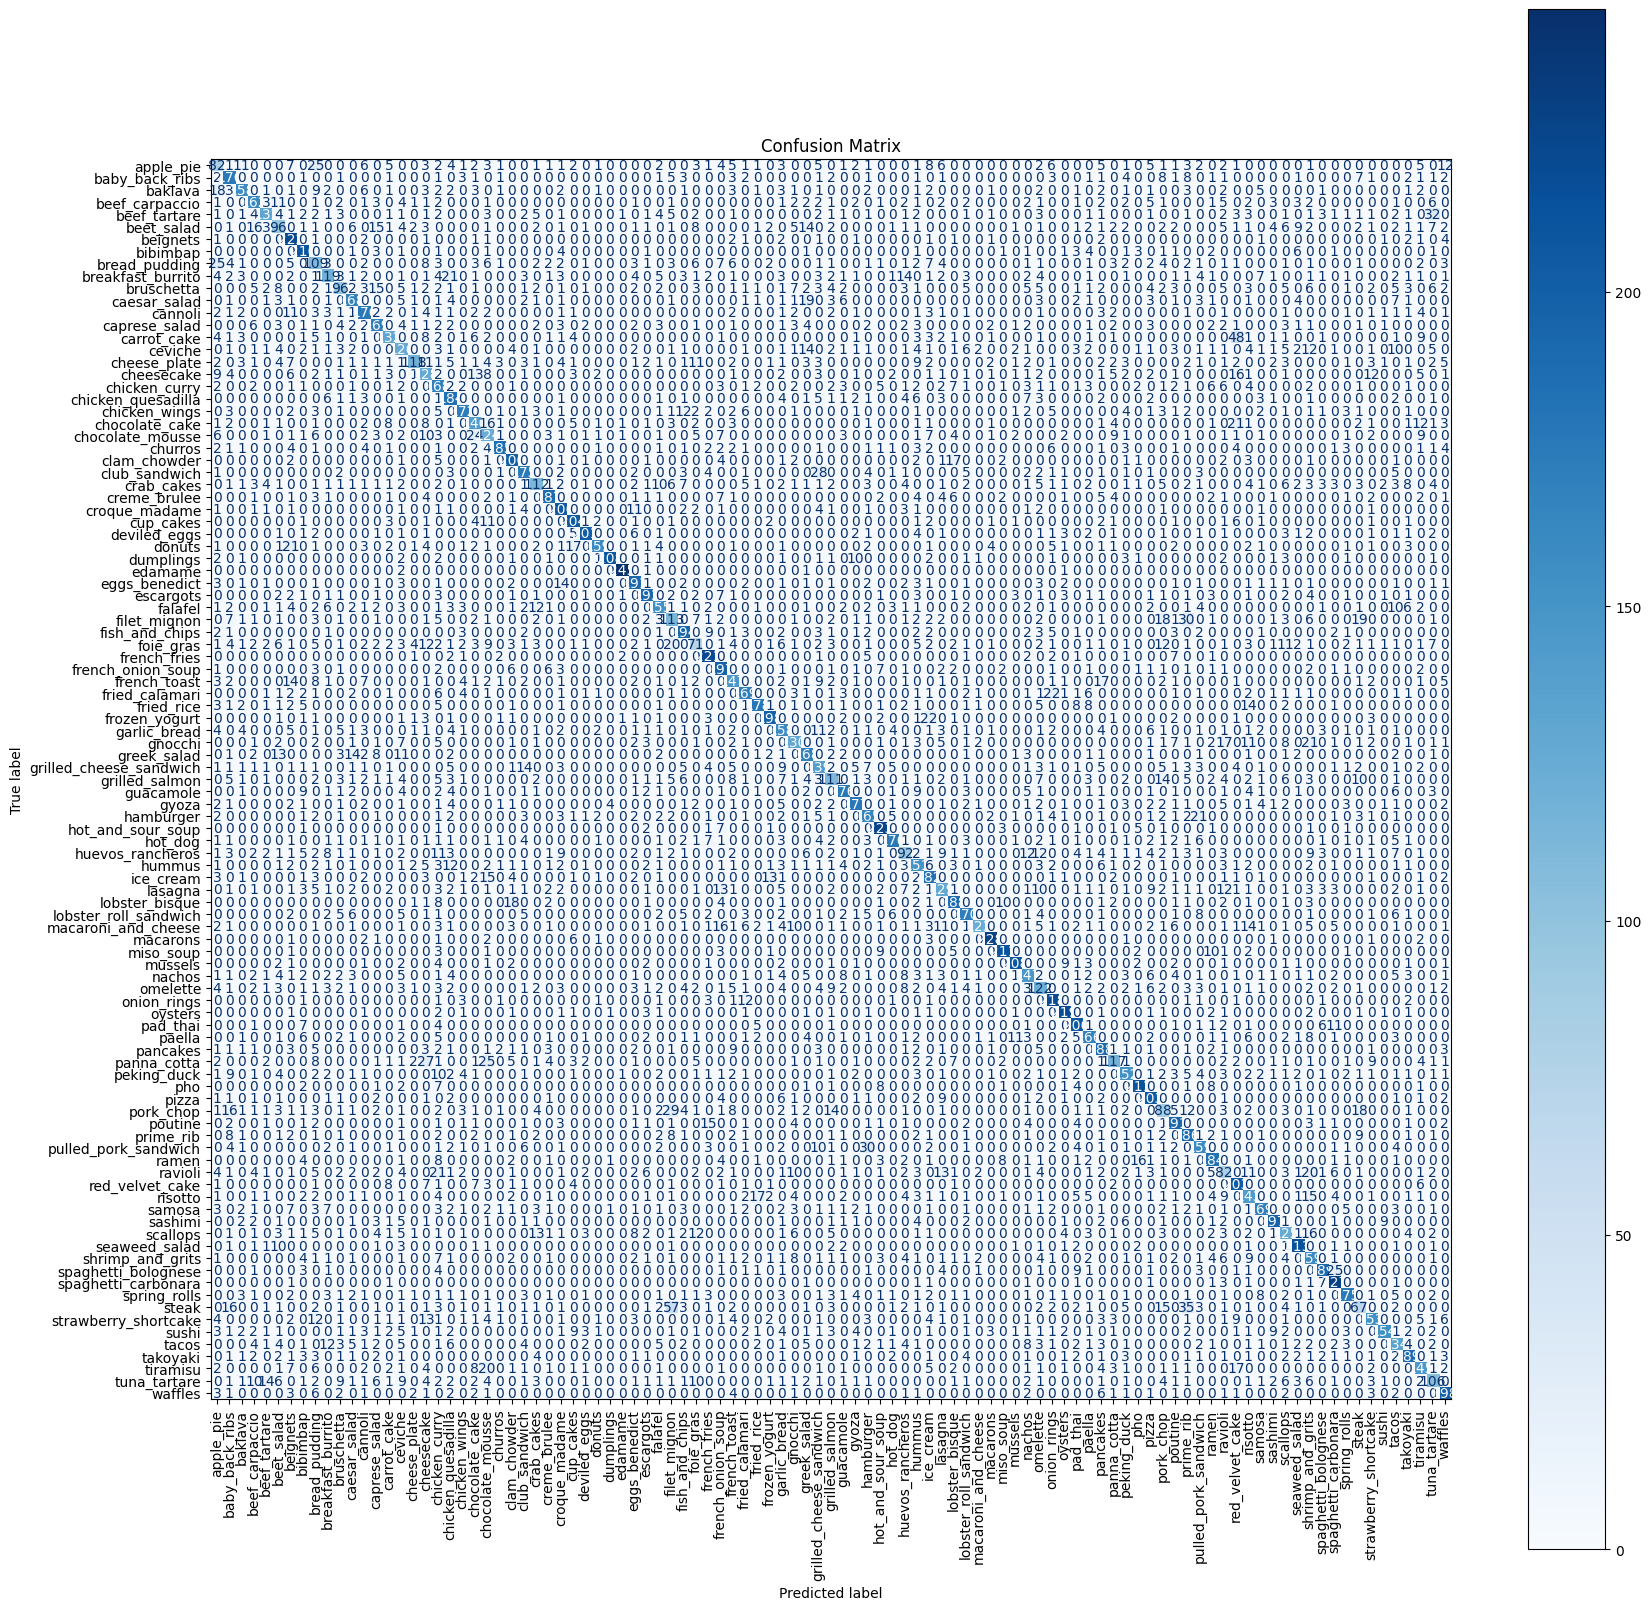

In [ ]:
# Step 5: Evaluate on the whole test data
model.eval()                       # Set the model to evaluation mode
test_correct = 0                   # Track correct predictions in test set
test_total = 0                     # Track total test predictions
all_labels = []                    # Initialize list to store true labels
all_predictions = []               # Initialize list to store predicted labels

with torch.no_grad():              # Disable gradient calculation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device

        with torch.cuda.amp.autocast():  # Enable mixed precision during evaluation for efficiency
            outputs = model(images)      # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted classes

        test_correct += (predicted == labels).sum().item()  # Count correct predictions
        test_total += labels.size(0)  # Count total predictions
        all_labels.extend(labels.cpu().numpy())        # Append true labels to the list
        all_predictions.extend(predicted.cpu().numpy())  # Append predictions to the list

test_accuracy = test_correct / test_total * 100  # Calculate test accuracy
print(f"Test Accuracy on the full test set: {test_accuracy:.2f}%")  # Print the test accuracy

# Step 6: Confusion Matrix Visualization
conf_matrix = confusion_matrix(all_labels, all_predictions)  # Compute the confusion matrix
plt.figure(figsize=(20, 20))  # Set the figure size
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)  # Create the display object
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=plt.gca())  # Plot the confusion matrix with blue color map
plt.title('Confusion Matrix')  # Add title to the plot
plt.show()  # Show the plot

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Step 7: Calculate Precision, Recall, and F1 Score
precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Weighted Precision: {precision:.2f}")
print(f"Weighted Recall: {recall:.2f}")
print(f"Weighted F1 Score: {f1:.2f}")

Weighted Precision: 0.66
Weighted Recall: 0.66
Weighted F1 Score: 0.65


# The End

# By
# Yassin Ehab —> 20216117
#Jana Soliman —> 20216129
#Menna Elminshawy —> 20217011